## Loading important modules

In [1]:
import numpy as np
import xarray as xr
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from cdo import Cdo
import dask.array as da
import matplotlib.cm as cm
import cmocean.cm as cmo

import nclcmaps 
import regression_analysis as rig
import matplotlib.pyplot as plt


/home/panini/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/panini/anaconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# Fiddle with figure settings here:
# plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 15
plt.rcParams['image.cmap'] = 'seismic'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)
cdo=Cdo()


## with CDO
1. selecting the date range,1979-2018
2. anomaly calculation
3. detrend the data
4. filter between 2-6 years
5.remove it from the daily anomaly

## data opening

In [ ]:
s_year = 1979
e_year = 2018
vari ='precip'

in_dir = '/home/panini/DATA/precip/'
in_netcdf = in_dir + 'GPCP.precip.mon.mean.nc'
ds = xr.open_dataset(in_netcdf)
times = pd.date_range(str(s_year)+'-01-01', str(e_year)+'-12-31', name='time', freq = 'M')
ds_sel = ds.sel(time = times, method='ffill') #nearest
ds_sel = ds_sel[vari]

In [ ]:
cdo=Cdo()
cdo.seldate(str(s_year)+'-01-01'','+str(e_year)+'-12-31',input=in_netcdf,output='temp1.nc')
cdo.sub(input = 'temp1.nc' + " -ymonmean " +'temp1.nc',output="GPCP_anom.nc")  #python# 
cdo.detrend(input='GPCP_anom.nc',output='det_GPCP_anom.nc')
cdo.bandpass("%f,%f" % (12./72.,12./24.), input="-setmisstoc,0 det_GPCP_anom.nc", output="GPCP_2-6yr.nc")
cdo.sub(input = 'GPCP_anom.nc'+' GPCP_2-6yr.nc',output="GPCP_precip_2-6yr_removed.nc")  #python# 
anomalies2=cdo.sub(input = 'GPCP_anom.nc'+' GPCP_2-6yr.nc',returnXArray='precip')  #python# 

!rm temp*.nc

In [ ]:
climatology = ds_sel.groupby('time.month').mean('time')
anomalies =ds_sel.groupby('time.month') - climatology  ## monthly anomaly of GPCP precipiataion
anomalies

## regressor making


### Option 1 non detrended index
### Option 0 detrended index

In [ ]:
option=0
if option:
    pdo=pd.read_fwf('/home/panini/DATA/indices/pdo_index.txt')
    amo=pd.read_fwf('/home/panini/DATA/indices/amo_index_short.txt')
    pdo_sel=pdo.set_index('YEAR').loc[s_year:e_year].values.ravel()
    amo_sel=amo.set_index('YEAR').loc[s_year:e_year].values.ravel()
    amo_sel.shape
else:
    pdo=pd.read_fwf('/home/panini/DATA/indices/pdo_index.txt')
    amo=pd.read_fwf('/home/panini/DATA/indices/amo_index_long.txt')
    pdo_temp=pdo.set_index('YEAR').loc[1900:2018].values.ravel()
    amo_temp=amo.set_index('YEAR').loc[1900:2018].values.ravel()

    missing = np.isnan(pdo_temp)
    pdo_new = pdo_temp[~missing]
    amo_new = amo_temp[~missing]


    pdo_temp_new=pdo_temp*1
    amo_temp_new=amo_temp*1

    detpdo,m1,c1=rig.detrend(pdo_new)
    detamo,m1,c1=rig.detrend(amo_new)


    pdo_temp_new[~missing]=detpdo
    amo_temp_new[~missing]=detamo

    # plt.plot(detamo)
    # plt.plot(amo_sel)
    # detamo1,m2,c2=rig.detrend(detamo)
    # plt.plot(m1*np.arange(len(detamo)+c1))
    # plt.plot(m2*np.arange(len(detamo1)+c2)

    pdo_temp1=pd.DataFrame(pdo_temp_new.reshape(2018-1900+1,12),index=pdo.set_index('YEAR').loc[1900:2018].index)
    amo_temp1=pd.DataFrame(amo_temp_new.reshape(2018-1900+1,12),index=pdo.set_index('YEAR').loc[1900:2018].index)

    pdo_sel=pdo_temp1.loc[s_year:e_year].values.ravel()
    amo_sel=amo_temp1.loc[s_year:e_year].values.ravel()
    amo_sel.shape

## Regressor loading

In [ ]:
global reg
reg = np.column_stack((pdo_sel,amo_sel))
reg= (reg- np.nanmean(reg,axis=0))/np.nanstd(reg,axis=0)

## regression function

In [ ]:
def xr_regression(y):
    X = sm.add_constant(reg, prepend=True) # regressor matrix
    mod = sm.OLS(y.values, X, missing = 'drop') # MLR analysis with AR2 modeling
    res = mod.fit()
    coefs=xr.DataArray(res.params[1:])
    return coefs

def model_fit(y):
    X = sm.add_constant(reg, prepend=True) # regressor matrix
    mod = sm.OLS(y.values, X, missing = 'drop') # MLR analysis with AR2 modeling
    res = mod.fit()
    fitdata=xr.DataArray(res.predict(X))
    return fitdata

## regression caluclation

In [ ]:
stacked = anomalies2.stack(allpoints = ['lat','lon']).squeeze()
stacked = stacked.reset_coords(drop=True)
coefs= stacked.groupby('allpoints').apply(xr_regression)
coefs_unstacked = coefs.unstack('allpoints')

## Visualization

In [ ]:
%matplotlib inline

coefs_unstacked.isel(dim_0 = [1]).squeeze().plot.contourf(yincrease=False)#, vmin=-1, vmax=1, cmap=plt.cm.RdBu_r)
coefs_unstacked.isel(dim_0 = [1]).squeeze().plot.contour(yincrease=False, colors='k', add_colorbar=False, \
                                                       levels = [-0.5, -0.2,-0.1,0,0.1,0.2, 0.5])


## linear fit data

In [ ]:
fitdata= stacked.groupby('allpoints').apply(model_fit)
fitdata_unstacked = fitdata.unstack('allpoints')
fitdata_unstacked.rename({'dim_0': 'time'})

## Removing the PDO/AMO from anomalies

In [ ]:
removed = anomalies2.values - fitdata_unstacked.values
ds_sel1 =ds.sel(time = times, method='ffill')


times     =   ds_sel1.time
lon       =   ds_sel1.lon
lat       =   ds_sel1.lat
t1       =     ds_sel1['precip']
t2       =     ds_sel1['precip']

t1        =   xr.DataArray(removed,coords=[('time', times),('lat', lat),('lon', lon)])
t2        =   xr.DataArray(fitdata_unstacked,coords=[('time', times),('lat', lat),('lon', lon)])

# dk2['precip']=t
# print(dk2.min())
# print (dk2.coords)
# print ('finished saving')
t1.to_netcdf('test1.nc')
t2.to_netcdf('test2.nc')

!cdo chname,__xarray_dataarray_variable__,precip -setgrid,r144X72 test1.nc test11.nc
!mv test11.nc precip.pdo.amo.removed.nc

!cdo chname,__xarray_dataarray_variable__,precip -setgrid,r144X72 test2.nc test22.nc
!mv test22.nc precip.pdo.amo.nc
!rm test*.nc

#### 1. Plot of raw precip trend
#### 2. plot 2-6 year variability removed trend
#### 3. plot PDO+AMO removed trend
#### 4. PDO+AMO trend

In [ ]:
cdo.trend(input ='GPCP_anom.nc',output='a.nc temp1.nc')
!rm a.nc
cdo.trend(input ='GPCP_precip_2-6yr_removed.nc',output='a.nc temp2.nc')
!rm a.nc
cdo.trend(input ='precip.pdo.amo.removed.nc',output='a.nc temp3.nc')
!rm a.nc
cdo.trend(input ='precip.pdo.amo.nc',output='a.nc temp4.nc')
!rm a.nc
cdo.mulc("120",input='temp1.nc',output='trend_gpcp_anom_all_year.nc')
cdo.mulc("120",input='temp2.nc',output='trend_gpcp_anom_all_year_removed_2-6yr.nc')
cdo.mulc("120",input='temp3.nc',output='trend_gpcp_anom_removed_pdo_amo.nc')
cdo.mulc("120",input='temp4.nc',output='trend_gpcp_anom_pdo_amo.nc')

!rm temp*.nc



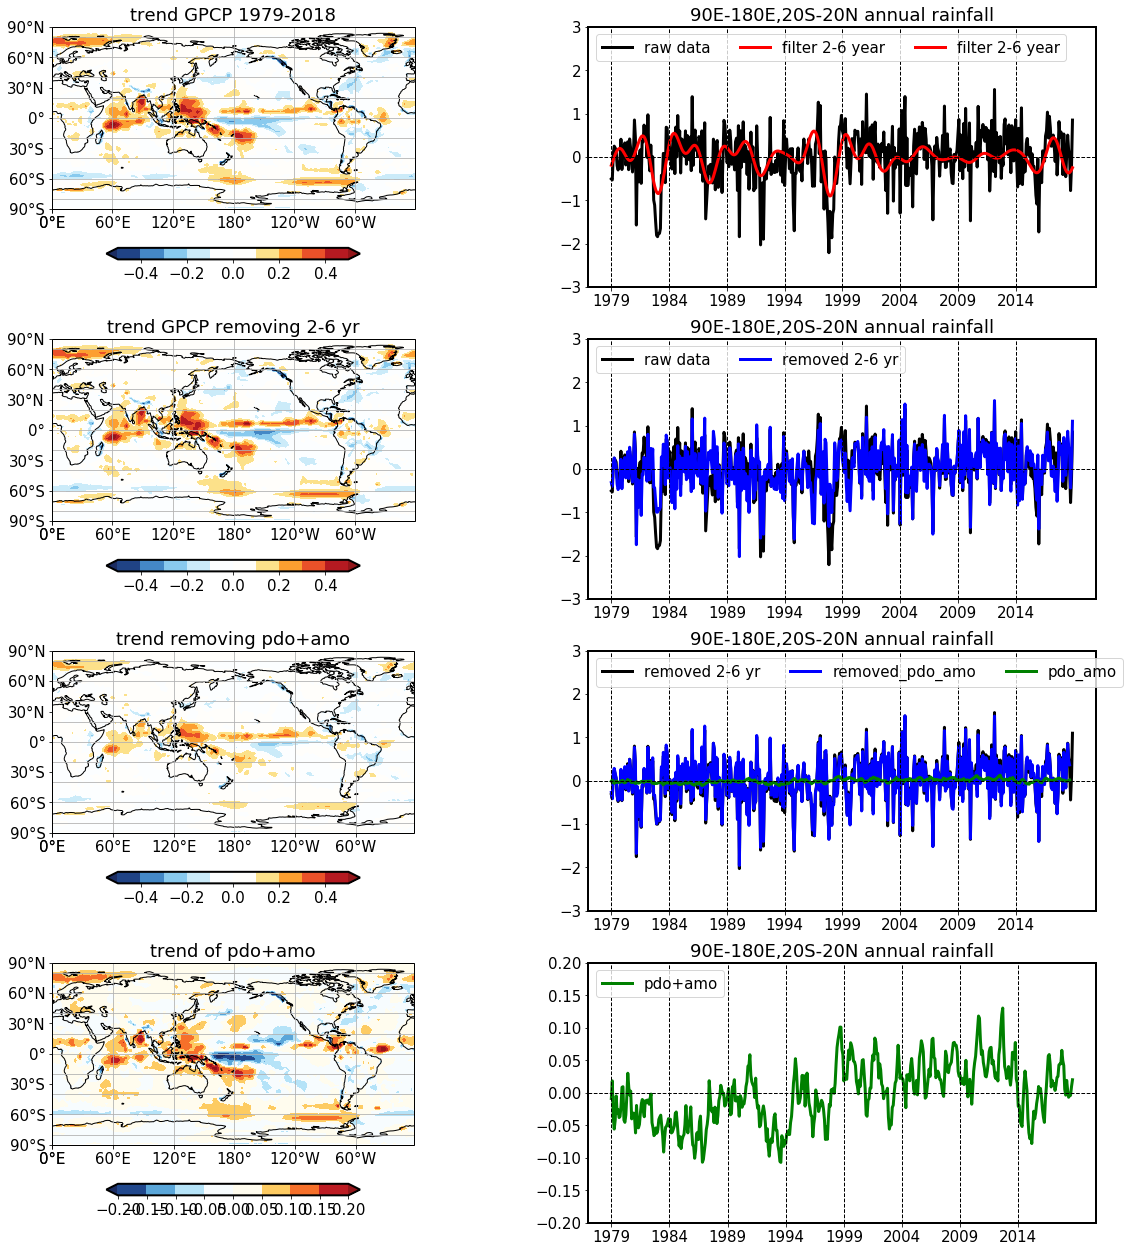

In [7]:
cmap1 = nclcmaps.cmap('BlueWhiteOrangeRed')
fig,ax=plt.subplots(4, 2,figsize=(20,22))


rig.draw_map_cartopy('trend_gpcp_anom_all_year.nc','precip',-0.5,0.5,.1,'trend GPCP 1979-2018',421,cmap=cmap1,hatch='/',draw_par=1)
rig.draw_map_cartopy('trend_gpcp_anom_all_year_removed_2-6yr.nc','precip',-0.5,0.5,.1,'trend GPCP removing 2-6 yr',423,cmap=cmap1,hatch='/',draw_par=1)
rig.draw_map_cartopy('trend_gpcp_anom_removed_pdo_amo.nc','precip',-0.5,0.5,.1,'trend removing pdo+amo',425,cmap=cmap1,hatch='/',draw_par=1)
rig.draw_map_cartopy('trend_gpcp_anom_pdo_amo.nc','precip',-0.2,0.2,.05,'trend of pdo+amo',427,cmap=cmap1,hatch='/',draw_par=1)



raw   = cdo.fldmean(input="-sellonlatbox,90,180,-20,20 GPCP_anom.nc",     options='-f nc', returnCdf=True)
filtered   = cdo.fldmean(input="-sellonlatbox,90,180,-20,20 GPCP_2-6yr.nc",     options='-f nc', returnCdf=True)
rm_26yr   = cdo.fldmean(input="-sellonlatbox,90,180,-20,20 GPCP_precip_2-6yr_removed.nc",     options='-f nc', returnCdf=True)
rm_pdo_amo   = cdo.fldmean(input="-sellonlatbox,90,180,-20,20 precip.pdo.amo.removed.nc", options='-f nc', returnCdf=True)
pdo_amo   = cdo.fldmean(input="-sellonlatbox,90,180,-20,20 precip.pdo.amo.nc", options='-f nc', returnCdf=True)

xx = np.arange(0,(2018-1979+1)*12,1)

ax[0,1].plot(xx,   raw.variables["precip"][:,0,0], "-", color="black", lw=3, label="raw data")
ax[0,1].plot(xx, filtered.variables["precip"][:,0,0],+raw.variables["precip"][:,0,0].mean(axis=0), "-", color="red", lw=3, label="filter 2-6 year")
ax[0,1].set_title("90E-180E,20S-20N annual rainfall")
ax[0,1].legend(loc=2,ncol=5)


ax[1,1].plot(xx,   raw.variables["precip"][:,0,0], "-", color="black", lw=3, label="raw data")
ax[1,1].plot(xx, rm_26yr.variables["precip"][:,0,0], "-", color="blue", lw=3, label="removed 2-6 yr")
ax[1,1].set_title("90E-180E,20S-20N annual rainfall")
ax[1,1].legend(loc=2,ncol=5)

ax[2,1].plot(xx,   rm_26yr.variables["precip"][:,0,0], "-", color="black", lw=3, label="removed 2-6 yr")
ax[2,1].plot(xx, rm_pdo_amo.variables["precip"][:,0,0], "-", color="blue", lw=3, label="removed_pdo_amo")
ax[2,1].plot(xx, pdo_amo.variables["precip"][:,0,0], "-", color="green", lw=3, label="pdo_amo")
ax[2,1].set_title("90E-180E,20S-20N annual rainfall")
ax[2,1].legend(loc=2,ncol=5)

ax[3,1].plot(xx, pdo_amo.variables["precip"][:,0,0], "-", color="green", lw=3, label="pdo+amo")
ax[3,1].set_title("90E-180E,20S-20N annual rainfall")
ax[3,1].legend(loc=2,ncol=5)


# plt.plot(xx, rm_filt.variables["precip"][:,0,0],"-", color="blue", lw=3, label="removed")
xx = np.arange(0,(2018-1980+1)*12,1)
xdata=np.arange(0,(2018-1980+1)*12,12*5)
xlabels=np.arange(1979,2017+1,5)

for i in np.arange(4):
    ax[i,1].set_xticks(xdata)
    ax[i,1].set_xticklabels(xlabels)
    ax[i,1].set_ylim((-3,3))
    ax[i,1].axhline(y=0,ls='--',linewidth=1, color='k')# ax.axhline(y=0,ls='--',linewidth=1, color='k')
    for x in xdata:
        ax[i,1].axvline(x=x,ls='--',linewidth=1,color='k')
    
# plt.legend(loc=2,ncol=4)  
ax[3,1].set_ylim((-0.2,0.2))

plt.savefig("adler_fig10.png")

## Winter 

## RAW / 2-6 years/ removed 2-6 year / removed PDO AMO/ PDO+AMO

In [ ]:
%%bash
# file="/home/panini/DATA/precip/GPCP.precip.mon.mean.nc"
# cdo sub $file -ymonmean $file anomalies.nc
for i in $(seq 1981 1 2017)
do
l=$((i + 1)) 
cdo selmon,11,12  -selyear,$i GPCP_anom.nc tempx.nc
cdo selmon,1,2,3,4 -selyear,$l GPCP_anom.nc tempy.nc
cdo mergetime tempx.nc tempy.nc jgr.nc
cdo timmean jgr.nc avg$i.nc
rm temp*.nc
rm jgr.nc
echo $NUM  
done

cdo mergetime avg*nc winter_avg_gpcp_1981-2017.nc
# cdo trend winter_avg_gpcp_1981-2017.nc a.nc trend_winter_gpcp.nc
rm avg*.nc
# rm a.nc

In [ ]:
%%bash
# file="/home/panini/DATA/precip/GPCP.precip.mon.mean.nc"
# cdo sub $file -ymonmean $file anomalies.nc
for i in $(seq 1981 1 2017)
do
l=$((i + 1)) 
cdo selmon,11,12  -selyear,$i GPCP_2-6yr.nc tempx.nc
cdo selmon,1,2,3,4 -selyear,$l GPCP_2-6yr.nc tempy.nc
cdo mergetime tempx.nc tempy.nc jgr.nc
cdo timmean jgr.nc avg$i.nc
rm temp*.nc
rm jgr.nc
echo $NUM  
done

cdo mergetime avg*nc winter_avg_gpcp_2-6_years_1981-2017.nc
# cdo trend winter_avg_gpcp_1981-2017.nc a.nc trend_winter_gpcp.nc
rm avg*.nc
# rm a.nc

In [ ]:
%%bash
for i in $(seq 1981 1 2017)
do
l=$((i + 1)) 
cdo selmon,11,12  -selyear,$i  GPCP_precip_2-6yr_removed.nc tempx.nc
cdo selmon,1,2,3,4 -selyear,$l GPCP_precip_2-6yr_removed.nc tempy.nc
cdo mergetime tempx.nc tempy.nc jgr.nc
cdo timmean jgr.nc avg$i.nc
rm temp*.nc
rm jgr.nc
echo $NUM  
done

# rm anomalies.nc
cdo mergetime avg*nc winter_avg_gpcp_1981-2017_2-6yr_removed.nc
# cdo trend winter_avg_gpcp_1981-2017_2-6yr_removed.nc a.nc trend_winter_gpcp_2-6yr_removed.nc
rm avg*.nc
# rm a.nc

In [ ]:
%%bash
for i in $(seq 1981 1 2017)
do
l=$((i + 1)) 
cdo selmon,11,12 -selyear,$i -selname,precip precip.pdo.amo.removed.nc tempx.nc
cdo selmon,1,2,3,4 -selyear,$l -selname,precip precip.pdo.amo.removed.nc tempy.nc
cdo mergetime tempx.nc tempy.nc jgr.nc
cdo timmean jgr.nc avg$i.nc
rm temp*.nc
rm jgr.nc
echo $NUM  
done


cdo mergetime avg*nc winter_avg_gpcp_1981-2017_pdo_amo_removed.nc
# cdo setcalendar,standard avgg.nc winter_avg_gpcp_1981-2017_pdo_amo_removed.nc
# cdo trend winter_avg_gpcp_1981-2017_smoothed.nc a.nc trend_winter_gpcp_smoothed.nc
rm avg*.nc
# rm a.nc

### ***  trend due to PDO and AMO *** ###

In [ ]:
%%bash
for i in $(seq 1981 1 2017)
do
l=$((i + 1)) 
cdo selmon,11,12 -selyear,$i -selname,precip precip.pdo.amo.nc tempx.nc
cdo selmon,1,2,3,4 -selyear,$l -selname,precip precip.pdo.amo.nc tempy.nc
cdo mergetime tempx.nc tempy.nc jgr.nc
cdo timmean jgr.nc avg$i.nc
rm temp*.nc
rm jgr.nc
echo $NUM  
done


cdo mergetime avg*nc winter_avg_gpcp_1981-2017_pdo_amo.nc
# cdo setcalendar,standard avgg.nc winter_avg_gpcp_1981-2017_smoothed.nc
# cdo trend winter_avg_gpcp_1981-2017_smoothed.nc a.nc trend_winter_gpcp_smoothed.nc
rm avg*.nc
# rm a.nc

##  Winter Trend 

In [ ]:
cdo.trend(input ='winter_avg_gpcp_1981-2017.nc',output='a.nc temp1.nc')
!rm a.nc
cdo.trend(input ='winter_avg_gpcp_1981-2017_2-6yr_removed.nc',output='a.nc temp2.nc')
!rm a.nc
cdo.trend(input ='winter_avg_gpcp_1981-2017_pdo_amo_removed.nc',output='a.nc temp3.nc')
!rm a.nc
cdo.trend(input ='winter_avg_gpcp_1981-2017_pdo_amo.nc',output='a.nc temp4.nc')
!rm a.nc
cdo.mulc("60",input='temp1.nc',output='trend_gpcp_anom_winter.nc')
cdo.mulc("60",input='temp2.nc',output='trend_gpcp_anom_winter_removed_2-6yr.nc')
cdo.mulc("60",input='temp3.nc',output='trend_gpcp_anom_winter_removed_pdo_amo.nc')
cdo.mulc("60",input='temp4.nc',output='trend_gpcp_anom_winter_pdo_amo.nc')

!rm temp*.nc

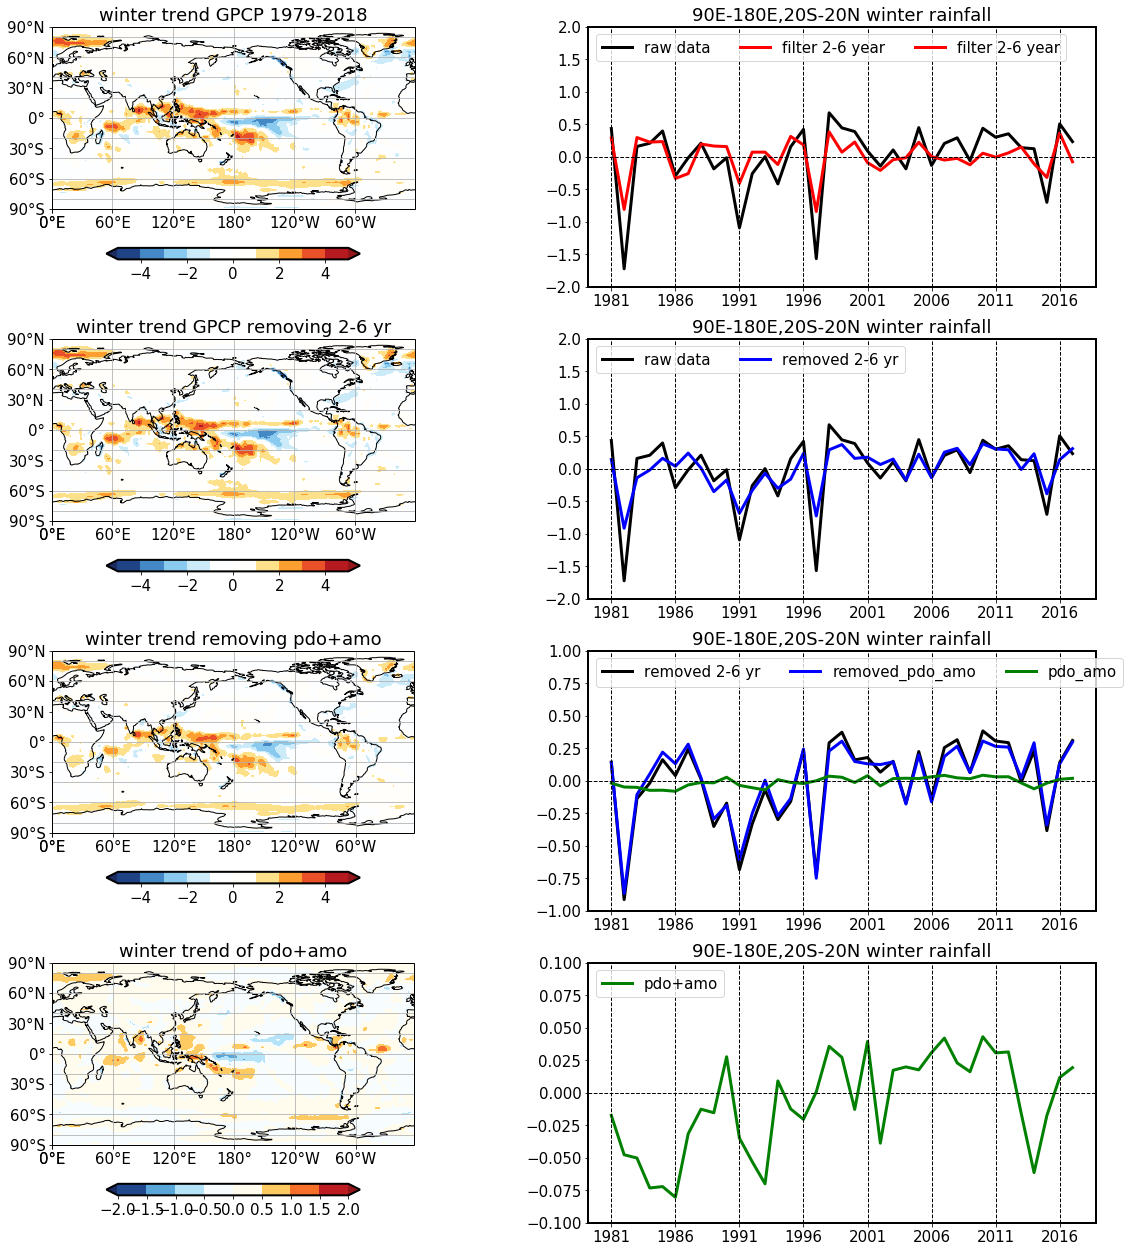

In [6]:
cmap1 = nclcmaps.cmap('BlueWhiteOrangeRed')
fig,ax=plt.subplots(4, 2,figsize=(20,22))


rig.draw_map_cartopy('trend_gpcp_anom_winter.nc','precip',-5,5,1,'winter trend GPCP 1979-2018',421,cmap=cmap1,hatch='/',draw_par=1)
rig.draw_map_cartopy('trend_gpcp_anom_winter_removed_2-6yr.nc','precip',-5,5,1,'winter trend GPCP removing 2-6 yr',423,cmap=cmap1,hatch='/',draw_par=1)
rig.draw_map_cartopy('trend_gpcp_anom_winter_removed_pdo_amo.nc','precip',-5,5,1,'winter trend removing pdo+amo',425,cmap=cmap1,hatch='/',draw_par=1)
rig.draw_map_cartopy('trend_gpcp_anom_winter_pdo_amo.nc','precip',-2,2,0.5,'winter trend of pdo+amo',427,cmap=cmap1,hatch='/',draw_par=1)



raw   = cdo.fldmean(input="-sellonlatbox,90,180,-20,20 winter_avg_gpcp_1981-2017.nc",     options='-f nc', returnCdf=True)
filtered   = cdo.fldmean(input="-sellonlatbox,90,180,-20,20 winter_avg_gpcp_2-6_years_1981-2017.nc",     options='-f nc', returnCdf=True)
rm_26yr   = cdo.fldmean(input="-sellonlatbox,90,180,-20,20 winter_avg_gpcp_1981-2017_2-6yr_removed.nc",     options='-f nc', returnCdf=True)
rm_pdo_amo   = cdo.fldmean(input="-sellonlatbox,90,180,-20,20 winter_avg_gpcp_1981-2017_pdo_amo_removed.nc", options='-f nc', returnCdf=True)
pdo_amo   = cdo.fldmean(input="-sellonlatbox,90,180,-20,20 winter_avg_gpcp_1981-2017_pdo_amo.nc", options='-f nc', returnCdf=True)

xx = np.arange(0,(2017-1981+1),1)

ax[0,1].plot(xx,   raw.variables["precip"][:,0,0], "-", color="black", lw=3, label="raw data")
ax[0,1].plot(xx, filtered.variables["precip"][:,0,0],+raw.variables["precip"][:,0,0].mean(axis=0), "-", color="red", lw=3, label="filter 2-6 year")
ax[0,1].set_title("90E-180E,20S-20N winter rainfall")
ax[0,1].legend(loc=2,ncol=5)


ax[1,1].plot(xx,   raw.variables["precip"][:,0,0], "-", color="black", lw=3, label="raw data")
ax[1,1].plot(xx, rm_26yr.variables["precip"][:,0,0], "-", color="blue", lw=3, label="removed 2-6 yr")
ax[1,1].set_title("90E-180E,20S-20N winter rainfall")
ax[1,1].legend(loc=2,ncol=5)

ax[2,1].plot(xx,   rm_26yr.variables["precip"][:,0,0], "-", color="black", lw=3, label="removed 2-6 yr")
ax[2,1].plot(xx, rm_pdo_amo.variables["precip"][:,0,0], "-", color="blue", lw=3, label="removed_pdo_amo")
ax[2,1].plot(xx, pdo_amo.variables["precip"][:,0,0], "-", color="green", lw=3, label="pdo_amo")
ax[2,1].set_title("90E-180E,20S-20N winter rainfall")
ax[2,1].legend(loc=2,ncol=5)

ax[3,1].plot(xx, pdo_amo.variables["precip"][:,0,0], "-", color="green", lw=3, label="pdo+amo")
ax[3,1].set_title("90E-180E,20S-20N winter rainfall")
ax[3,1].legend(loc=2,ncol=5)

# plt.plot(xx, rm_filt.variables["precip"][:,0,0],"-", color="blue", lw=3, label="removed")
xx = np.arange(0,(2018-1981+1),1)
xdata=np.arange(0,(2018-1981+1),5)
xlabels=np.arange(1981,2017+1,5)

for i in np.arange(4):
    ax[i,1].set_xticks(xdata)
    ax[i,1].set_xticklabels(xlabels)
    ax[i,1].set_ylim((-2,2))
    ax[i,1].axhline(y=0,ls='--',linewidth=1, color='k')# ax.axhline(y=0,ls='--',linewidth=1, color='k')
    for x in xdata:
        ax[i,1].axvline(x=x,ls='--',linewidth=1,color='k')
    
# plt.legend(loc=2,ncol=4)  
ax[2,1].set_ylim((-1,1))

ax[3,1].set_ylim((-0.1,0.1))

plt.savefig("winter_trend_GPCP.png")

## trend Analysis using my codes

In [3]:
import nclcmaps 
import regression_analysis as rig
import matplotlib.pyplot as plt
cmap1 = nclcmaps.cmap('BlueWhiteOrangeRed')

In [4]:
P=rig.reg_plot()
P.explain_to()
time_series=np.arange(1,38,1)
var_name='precip'
alpha=0.05
# cmap=cmo.delta

Hello, users. These are inputs:
Your time series is [].
Your data filename is .
Your variable name is .
significance level is 0.


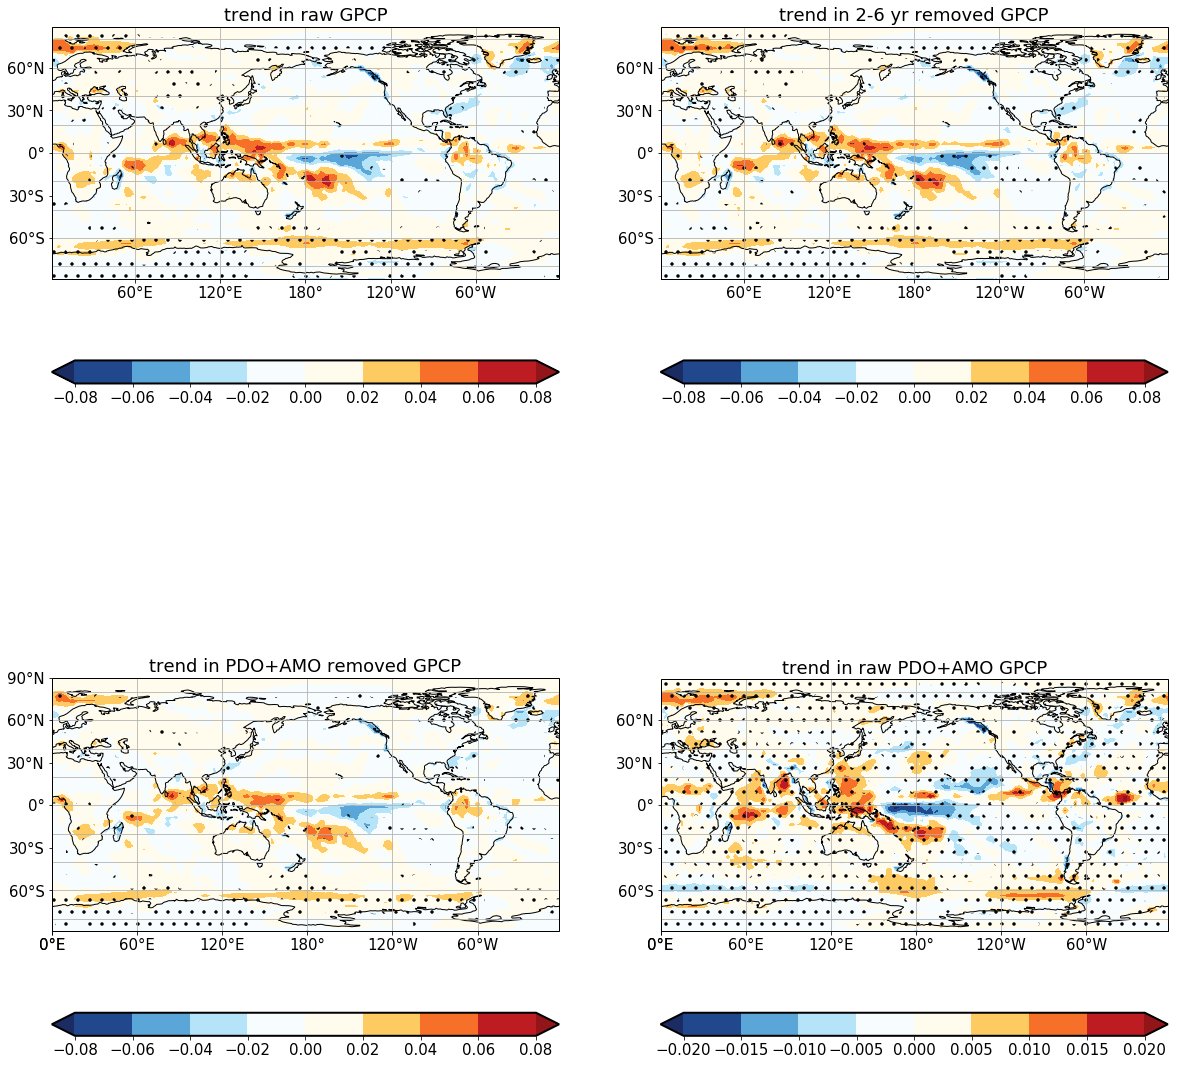

In [8]:
fig,ax=plt.subplots(2, 2,figsize=(20,22))

data_name="winter_avg_gpcp_1981-2017.nc"
P=rig.reg_plot(time_series,data_name,var_name,alpha,opt_detrend=0,opt_mktest=1)
P.regression_map_making()
P.draw_regression_cartopy(-0.08,0.08,.02,"trend in raw GPCP",221,cmap=cmap1,hatch='.',draw_par=1)


data_name="winter_avg_gpcp_1981-2017_2-6yr_removed.nc"
P=rig.reg_plot(time_series,data_name,var_name,alpha,opt_detrend=0,opt_mktest=1)
P.regression_map_making()
P.draw_regression_cartopy(-0.08,0.08,.02,"trend in 2-6 yr removed GPCP",222,cmap=cmap1,hatch='.',draw_par=1)

data_name="winter_avg_gpcp_1981-2017_pdo_amo_removed.nc"
P=rig.reg_plot(time_series,data_name,var_name,alpha,opt_detrend=0,opt_mktest=1)
P.regression_map_making()
P.draw_regression_cartopy(-0.08,0.08,.02,"trend in PDO+AMO removed GPCP",223,cmap=cmap1,hatch='.',draw_par=1)

data_name="winter_avg_gpcp_1981-2017_pdo_amo.nc"
P=rig.reg_plot(time_series,data_name,var_name,alpha,opt_detrend=0,opt_mktest=1)
P.regression_map_making()
P.draw_regression_cartopy(-0.02,0.02,.005,"trend in raw PDO+AMO GPCP",224,cmap=cmap1,hatch='.',draw_par=1)
plt.savefig("trend_winter.png")

In [9]:
# raw   = cdo.fldmean(input="-sellonlatbox,90,180,-20,20 winter_avg_gpcp_1981-2017.nc",     options='-f nc', returnCdf=True)
filtered   = cdo.fldmean(input="-sellonlatbox,90,180,-20,20 winter_avg_gpcp_2-6_years_1981-2017.nc",     options='-f nc', returnCdf=True)
rm_26yr   = cdo.fldmean(input="-sellonlatbox,90,180,-20,20 winter_avg_gpcp_1981-2017_2-6yr_removed.nc",     options='-f nc', returnCdf=True)
rm_pdo_amo   = cdo.fldmean(input="-sellonlatbox,90,180,-20,20 winter_avg_gpcp_1981-2017_pdo_amo_removed.nc", options='-f nc', returnCdf=True)
pdo_amo   = cdo.fldmean(input="-sellonlatbox,90,180,-20,20 winter_avg_gpcp_1981-2017_pdo_amo.nc", options='-f nc', returnCdf=True)
x=np.asarray(raw.variables["precip"][:,0,0])
trend,h,p,z = rig.mk_test(x,0.05)
trend,p

('increasing', 0.004236836371846575)